In [11]:
# Libraries

import pandas as pd
import time
import numpy as np
import random
import os
from tqdm import tqdm

# Data Analysis
import plotly.express as px
import matplotlib.pyplot as plt
import seaborn as sns

#TensorFlow
import tensorflow as tf
from tensorflow.keras.preprocessing.image import array_to_img

# Sklearn
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.model_selection import train_test_split

# Classes Tensorflow
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv2D, Dropout, Flatten, MaxPooling2D, GlobalAveragePooling2D
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications import EfficientNetB1

%matplotlib inline

## Preprocessing

In [3]:
train_dir = 'D:/documents/GitHub/Radios_COVID19/COVID-19_Radiography_Dataset'

normal_imgs = [fn for fn in os.listdir(f'{train_dir}/Normal/images') if fn.endswith('.png')]
covid_imgs = [fn for fn in os.listdir(f'{train_dir}/COVID/images') if fn.endswith('.png')]
pneumonia_imgs = [fn for fn in os.listdir(f'{train_dir}/Viral Pneumonia/images') if fn.endswith('.png')]
lung_opacity_imgs = [fn for fn in os.listdir(f'{train_dir}/Lung_Opacity/images') if fn.endswith('.png')]

In [4]:
#Randomly select X of each images
random_sample = 400

select_norm = np.random.choice(normal_imgs, random_sample, replace = False)
select_covid = np.random.choice(covid_imgs, random_sample, replace = False)
select_pneumonia = np.random.choice(pneumonia_imgs, random_sample, replace = False)
select_lung_opacity = np.random.choice(lung_opacity_imgs, random_sample, replace = False)

In [5]:
liste = []

for fn in select_norm :
    liste.append(f'{train_dir}/Normal/images/' + fn)
for fn in select_covid :
    liste.append(f'{train_dir}/COVID/images/' + fn)
for fn in select_pneumonia :
    liste.append(f'{train_dir}/Viral Pneumonia/images/' + fn)
for fn in select_lung_opacity :
    liste.append(f'{train_dir}/Lung_Opacity/images/' + fn)

liste = list(map(lambda x : [x, x.split('/')[5]], liste))

In [6]:
#Créer un DataFrame pandas
df = pd.DataFrame(liste, columns = ['filepath', 'nameLabel'])
df['label'] = df['nameLabel'].replace(df.nameLabel.unique(), [*range(len(df.nameLabel.unique()))]).astype(str)

print('DataFrame size : ', df.shape)
print(df['nameLabel'].value_counts())
df.head()

DataFrame size :  (1600, 3)
Normal             400
COVID              400
Viral Pneumonia    400
Lung_Opacity       400
Name: nameLabel, dtype: int64


,filepath,nameLabel,label
0,D:/documents/GitHub/Radios_COVID19/COVID-19_Ra...,Normal,0
1,D:/documents/GitHub/Radios_COVID19/COVID-19_Ra...,Normal,0
2,D:/documents/GitHub/Radios_COVID19/COVID-19_Ra...,Normal,0
3,D:/documents/GitHub/Radios_COVID19/COVID-19_Ra...,Normal,0
4,D:/documents/GitHub/Radios_COVID19/COVID-19_Ra...,Normal,0


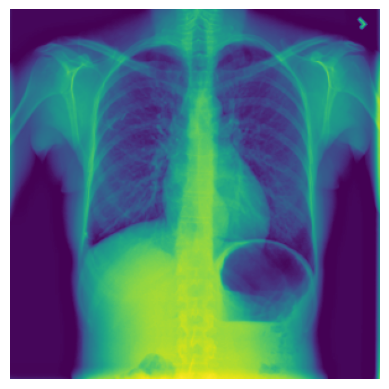

In [7]:
#Charger Exemple Image
filepath = df.filepath[9]

im = tf.io.read_file(filepath)
im = tf.image.decode_jpeg(im, channels = 1)
plt.imshow(im)
plt.axis('off');

In [8]:
size = 256 #Image size (depending on model definition)
ratio_val = 0.2 #percentage of dataset to be held into test
batch_generator = 32

train_data_generator = ImageDataGenerator( )
test_data_generator = ImageDataGenerator( )

# Création des itérateurs qui chargeront des lots d'images
train, test = train_test_split(df, test_size = ratio_val)

print(f"Number of rows in train set: {len(train)}")

train_generator = train_data_generator.flow_from_dataframe(dataframe = train,
                                                           x_col="filepath",
                                                           y_col="label",
                                                           class_mode = "sparse",
                                                           target_size = (size,size),
                                                           batch_size = batch_generator,
                                                           color_mode = "grayscale")

print(f"Number of rows in test set: {len(test)}")
test_generator = test_data_generator.flow_from_dataframe(dataframe = test,
                                                         x_col="filepath",
                                                         y_col="label",
                                                         class_mode = "sparse",
                                                         target_size = (size,size),
                                                         batch_size = batch_generator,
                                                         color_mode = "grayscale",
                                                         shuffle=False) 


Number of rows in train set: 1280
Found 1280 validated image filenames belonging to 4 classes.
Number of rows in test set: 320
Found 320 validated image filenames belonging to 4 classes.


## EfficientNetB1 Model

In [9]:
# Chargement du modèle efficientNet
efficientNet = EfficientNetB1(include_top = False, input_shape = (256,256,3))

# Bloquage du blackbone
for layer in efficientNet.layers:
    layer.trainable = False
    
efficientNet.summary()

27018416/27018416 [==============================] - 1s 0us/step
Model: "efficientnetb1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 256, 256, 3  0           []                               
                                )]                                                                
                                                                                                  
 rescaling (Rescaling)          (None, 256, 256, 3)  0           ['input_1[0][0]']                
                                                                                                  
 normalization (Normalization)  (None, 256, 256, 3)  7           ['rescaling[0][0]']              
                                                                                                  
 rescaling_1 (Rescal

                                )                                 'block1a_project_bn[0][0]']     
                                                                                                  
 block2a_expand_conv (Conv2D)   (None, 128, 128, 96  1536        ['block1b_add[0][0]']            
                                )                                                                 
                                                                                                  
 block2a_expand_bn (BatchNormal  (None, 128, 128, 96  384        ['block2a_expand_conv[0][0]']    
 ization)                       )                                                                 
                                                                                                  
 block2a_expand_activation (Act  (None, 128, 128, 96  0          ['block2a_expand_bn[0][0]']      
 ivation)                       )                                                                 
          

                                                                                                  
 block2c_expand_activation (Act  (None, 64, 64, 144)  0          ['block2c_expand_bn[0][0]']      
 ivation)                                                                                         
                                                                                                  
 block2c_dwconv (DepthwiseConv2  (None, 64, 64, 144)  1296       ['block2c_expand_activation[0][0]
 D)                                                              ']                               
                                                                                                  
 block2c_bn (BatchNormalization  (None, 64, 64, 144)  576        ['block2c_dwconv[0][0]']         
 )                                                                                                
                                                                                                  
 block2c_a

 block3b_bn (BatchNormalization  (None, 32, 32, 240)  960        ['block3b_dwconv[0][0]']         
 )                                                                                                
                                                                                                  
 block3b_activation (Activation  (None, 32, 32, 240)  0          ['block3b_bn[0][0]']             
 )                                                                                                
                                                                                                  
 block3b_se_squeeze (GlobalAver  (None, 240)         0           ['block3b_activation[0][0]']     
 agePooling2D)                                                                                    
                                                                                                  
 block3b_se_reshape (Reshape)   (None, 1, 1, 240)    0           ['block3b_se_squeeze[0][0]']     
          

                                                                                                  
 block4a_activation (Activation  (None, 16, 16, 240)  0          ['block4a_bn[0][0]']             
 )                                                                                                
                                                                                                  
 block4a_se_squeeze (GlobalAver  (None, 240)         0           ['block4a_activation[0][0]']     
 agePooling2D)                                                                                    
                                                                                                  
 block4a_se_reshape (Reshape)   (None, 1, 1, 240)    0           ['block4a_se_squeeze[0][0]']     
                                                                                                  
 block4a_se_reduce (Conv2D)     (None, 1, 1, 10)     2410        ['block4a_se_reshape[0][0]']     
          

                                                                                                  
 block4c_se_expand (Conv2D)     (None, 1, 1, 480)    10080       ['block4c_se_reduce[0][0]']      
                                                                                                  
 block4c_se_excite (Multiply)   (None, 16, 16, 480)  0           ['block4c_activation[0][0]',     
                                                                  'block4c_se_expand[0][0]']      
                                                                                                  
 block4c_project_conv (Conv2D)  (None, 16, 16, 80)   38400       ['block4c_se_excite[0][0]']      
                                                                                                  
 block4c_project_bn (BatchNorma  (None, 16, 16, 80)  320         ['block4c_project_conv[0][0]']   
 lization)                                                                                        
          

                                                                                                  
 block5a_project_conv (Conv2D)  (None, 16, 16, 112)  53760       ['block5a_se_excite[0][0]']      
                                                                                                  
 block5a_project_bn (BatchNorma  (None, 16, 16, 112)  448        ['block5a_project_conv[0][0]']   
 lization)                                                                                        
                                                                                                  
 block5b_expand_conv (Conv2D)   (None, 16, 16, 672)  75264       ['block5a_project_bn[0][0]']     
                                                                                                  
 block5b_expand_bn (BatchNormal  (None, 16, 16, 672)  2688       ['block5b_expand_conv[0][0]']    
 ization)                                                                                         
          

                                                                                                  
 block5d_expand_conv (Conv2D)   (None, 16, 16, 672)  75264       ['block5c_add[0][0]']            
                                                                                                  
 block5d_expand_bn (BatchNormal  (None, 16, 16, 672)  2688       ['block5d_expand_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 block5d_expand_activation (Act  (None, 16, 16, 672)  0          ['block5d_expand_bn[0][0]']      
 ivation)                                                                                         
                                                                                                  
 block5d_dwconv (DepthwiseConv2  (None, 16, 16, 672)  16800      ['block5d_expand_activation[0][0]
 D)       

 ivation)                                                                                         
                                                                                                  
 block6b_dwconv (DepthwiseConv2  (None, 8, 8, 1152)  28800       ['block6b_expand_activation[0][0]
 D)                                                              ']                               
                                                                                                  
 block6b_bn (BatchNormalization  (None, 8, 8, 1152)  4608        ['block6b_dwconv[0][0]']         
 )                                                                                                
                                                                                                  
 block6b_activation (Activation  (None, 8, 8, 1152)  0           ['block6b_bn[0][0]']             
 )                                                                                                
          

 block6d_bn (BatchNormalization  (None, 8, 8, 1152)  4608        ['block6d_dwconv[0][0]']         
 )                                                                                                
                                                                                                  
 block6d_activation (Activation  (None, 8, 8, 1152)  0           ['block6d_bn[0][0]']             
 )                                                                                                
                                                                                                  
 block6d_se_squeeze (GlobalAver  (None, 1152)        0           ['block6d_activation[0][0]']     
 agePooling2D)                                                                                    
                                                                                                  
 block6d_se_reshape (Reshape)   (None, 1, 1, 1152)   0           ['block6d_se_squeeze[0][0]']     
          

                                                                                                  
 block7a_se_squeeze (GlobalAver  (None, 1152)        0           ['block7a_activation[0][0]']     
 agePooling2D)                                                                                    
                                                                                                  
 block7a_se_reshape (Reshape)   (None, 1, 1, 1152)   0           ['block7a_se_squeeze[0][0]']     
                                                                                                  
 block7a_se_reduce (Conv2D)     (None, 1, 1, 48)     55344       ['block7a_se_reshape[0][0]']     
                                                                                                  
 block7a_se_expand (Conv2D)     (None, 1, 1, 1152)   56448       ['block7a_se_reduce[0][0]']      
                                                                                                  
 block7a_s

In [12]:
# Partie Classification

model = Sequential()
model.add(efficientNet)
model.add(GlobalAveragePooling2D())
model.add(Dense(1024, activation = 'relu'))
model.add(Dropout(0.2))
model.add(Dense(512, activation = 'relu'))
model.add(Dropout(0.2))
model.add(Dense(4, activation = 'softmax'))

model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 efficientnetb1 (Functional)  (None, 8, 8, 1280)       6575239   
                                                                 
 global_average_pooling2d (G  (None, 1280)             0         
 lobalAveragePooling2D)                                          
                                                                 
 dense (Dense)               (None, 1024)              1311744   
                                                                 
 dropout (Dropout)           (None, 1024)              0         
                                                                 
 dense_1 (Dense)             (None, 512)               524800    
                                                                 
 dropout_1 (Dropout)         (None, 512)               0         
                                                      

In [14]:
# Compilation
optimizer = tf.keras.optimizers.Adam(learning_rate = 0.001)

model.compile(loss = "sparse_categorical_crossentropy", optimizer = optimizer, metrics = ["accuracy"])

## Entrainement Modèle

In [15]:
# Entrainement du modèle
train_size = train_generator.samples
test_size = test_generator.samples

batch_model = 32
epochs = 10

history = model.fit(train_generator,
                    epochs = epochs,
                    steps_per_epoch = train_size // batch_model,
                    validation_data = test_generator,
                    validation_steps = test_size // batch_model)

Epoch 1/10
40/40 [==============================] - 89s 2s/step - loss: 0.7424 - accuracy: 0.6961 - val_loss: 0.5068 - val_accuracy: 0.8000
Epoch 2/10
40/40 [==============================] - 75s 2s/step - loss: 0.4484 - accuracy: 0.8211 - val_loss: 0.3989 - val_accuracy: 0.8219
Epoch 3/10
40/40 [==============================] - 70s 2s/step - loss: 0.3492 - accuracy: 0.8633 - val_loss: 0.3469 - val_accuracy: 0.8656
Epoch 4/10
40/40 [==============================] - 69s 2s/step - loss: 0.3367 - accuracy: 0.8641 - val_loss: 0.3800 - val_accuracy: 0.8500
Epoch 5/10
40/40 [==============================] - 72s 2s/step - loss: 0.2991 - accuracy: 0.8773 - val_loss: 0.3772 - val_accuracy: 0.8687
Epoch 6/10
40/40 [==============================] - 68s 2s/step - loss: 0.2635 - accuracy: 0.9031 - val_loss: 0.4987 - val_accuracy: 0.8313
Epoch 7/10
40/40 [==============================] - 71s 2s/step - loss: 0.2188 - accuracy: 0.9211 - val_loss: 0.3261 - val_accuracy: 0.8719
Epoch 8/10
40/40 [==

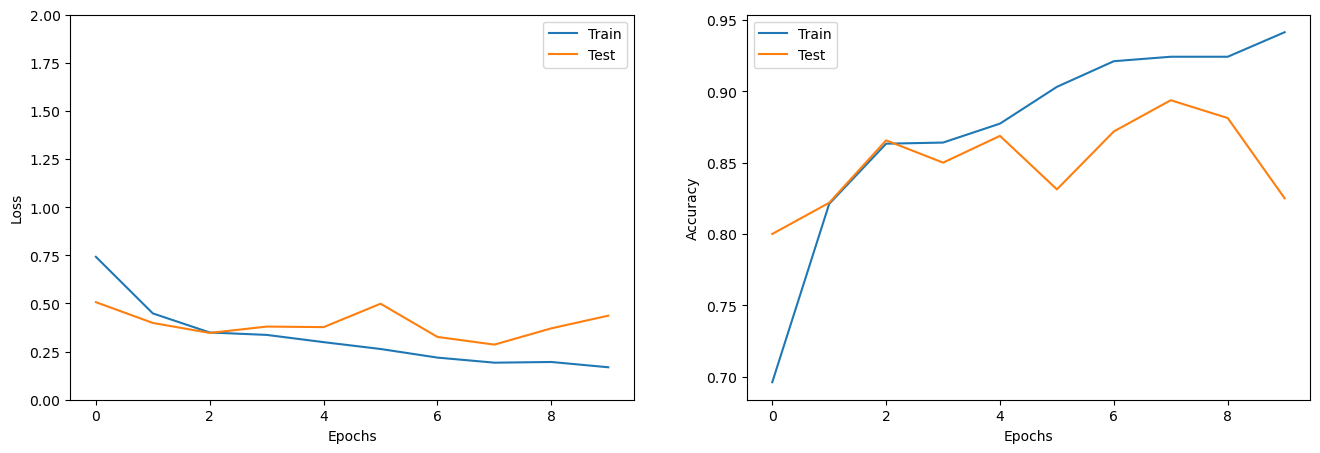

In [16]:
# Courbes de perte et d'accuracy
plt.figure(figsize = (16,5))

plt.subplot(121)
plt.plot(history.history["loss"], label = "Train")
plt.plot(history.history["val_loss"], label = "Test")
plt.legend()
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.ylim(0,2)

plt.subplot(122)
plt.plot(history.history["accuracy"], label = "Train")
plt.plot(history.history["val_accuracy"], label = "Test")
plt.legend()
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.show();

## Model Performance 

In [17]:
# Prédictions (probabilités)
test_generator.reset()
test_pred_lenet = model.predict(test_generator, verbose = 1 )

10/10 [==============================] - 16s 1s/step


In [18]:
# Récupération des classes à partir des probabilités
test_pred_lenet_class = test_pred_lenet.argmax(axis = 1)

# Matrice de confusion
print(confusion_matrix(test_generator.classes, test_pred_lenet_class))

[[43 28  6  9]
 [ 1 75  1  1]
 [ 0  0 82  0]
 [ 3  7  0 64]]


In [19]:
print(classification_report(test_generator.classes, test_pred_lenet_class, target_names=test_generator.class_indices.keys()))

              precision    recall  f1-score   support

           0       0.91      0.50      0.65        86
           1       0.68      0.96      0.80        78
           2       0.92      1.00      0.96        82
           3       0.86      0.86      0.86        74

    accuracy                           0.82       320
   macro avg       0.85      0.83      0.82       320
weighted avg       0.85      0.82      0.81       320

